## PERMGWAS 
In the method obtained as a result of the GWAS analysis, it was thought that the false positive SNPs were more than expected. It is thought that the presence of too many regulator genes in the network map to be created and the false positive error being more than expected. For this reason, using permgwas instead of classical bonferroni correction, other filtering steps were repeated according to these new permGWAS results. In this study, the results before repeating the prefiletering, which was done before the GWAS analysis in the previous method, were used. In this way, permGWAS analysis was performed with significant 738 phenotype files. The phenotype and genotype files used are the same, and permGWAS does not need a kinship file. The permGWAS used in this study is an open source tool, downloaded from https://github.com/grimmlab/permGWAS.git and detailed information can be found here. After the necessary tools are downloaded, the phenotype and genotype file locations are specified, the appropriate permutation number (perm has been determined as 100 for this study) is entered and python is run in the batch environment. In this way, PermGWAS analysis is done.

In [ ]:
#!/bin/bash
FILES=(AT*.csv)
FILE=${FILES[$SLURM_ARRAY_TASK_ID]}
singularity exec --bind /storage/full-share/permGWAS permgwas.sing python3 permGWAS/permGWAS.py -x F95.h5 -y ${FILE}  --out_dir outfile_${FILE} --perm 100


### 1. PermGWAS Threshold 
In this section, new thresold are found for each of the perm GWAS results seperatly. The reason of the the using different threshold each of the result is reduce false positive ratio, compare to the bonferroni correction.Every min p value file contain only first minimum 100 p values. Min p values are reordered accorging to their p values. After that cut off value are decided to 5 th of the p value (0.05. These p values are decided each of the permGWAS result seperatly. Each of the thresholds are used to filter permGWAS results and saved (filter_permgwas.r).

In [ ]:
%%R
##permgwas:find pvalue_threshold each phenotype separetly then apply this threshold value for filtering step
library(tidyverse)
library(fs)
setwd("~/lastversion_gwas_analysis/PermGWAS_Scripts/")

list_of_files <- list.files(path = "~/PermGWAS/",
                            recursive = TRUE,
                            pattern = "*min_",
                            full.names = TRUE)
Y <- lapply(list_of_files, function(x) {
  file <- read.csv(x)
  return(file)
})
###find perm_threshold for each phenotype
new_list<-vector()
for (i in 1:length((list_of_files))){
  A<-Y[[i]][order(Y[[i]][,2]),]
  perm_thres<-A[5,2]
  new_list<-c(new_list,perm_thres)
  new_list<-as.matrix(new_list, sep=",")
  new<-as.data.frame(new_list)
}
####use this threshold and filter perm_gwas result

csv_files <- list.files(path = "~/PermGWAS/",
                            recursive = TRUE,
                            pattern = "*gwasp_",
                            full.names = TRUE)
Y_ <- lapply(csv_files, function(x) {
  file <- read.csv(x)
  return(file)
})
a<-read.csv("~/lastversion_gwas_analysis/names.csv")
for (i in 1:length((csv_files))){
  R<-subset(Y_[[i]],Y_[[i]][["p_value"]]<(new[i,]))
  write.csv(R, file=paste(a$x[i] , sep=""))
}


### 2. MAF filter
In this part, MAF (Minnor Allele Frequency) value is less than 5 is discarded from insdide of the all files and saved. Minnor Allele Frequency is the frequency that second most found allele occured in a population, studies showed that it has a major affect on traits (). The rest of the steps are continue with this new filtered files (mac_maf.r).

In [ ]:
%%R
#maf filtered >0.05

library(tidyverse)
library(fs)
setwd("~/lastversion_gwas_analysis/PermGWAS_Scripts/permgwas_filtered_pvalue/")

Y <- list()
csvfiles<-list.files(pattern = "*.csv")

Y <- lapply(csvfiles, function(x) {
  file <- read.csv(x)
  return(file)
})

for (i in 1:length((list_of_files))){
  R<-subset(Y[[i]],Y[[i]][["maf"]]>0.05)
  write.csv(R, file=paste( "filtered_",csvfiles[i],".csv", sep=""))
}


### Count hits
Stringent bonferroni correction files are used to count cis and trans hits. Each stringent bonferroni corrected files are used. The second gene name is taken from the name of these files. Each SNPs position given in these files is valued according to the Start and Stop positions in the gene location file. If these SNPs positions are between the Start and Stop position, the SNPs at that position are called cis_hits, otherwise they are called trans hits. In this way, the number of cis hits for each file is subtracted from the total number of SNPs (hits) and the number of trans hits is found.
### Count cis and trans hits
After counting cis hits, trans hits counted to sustraction of total hits to cis hits. New column added to the list as when the file contain cis hits it represented with 1, othervise 0. New column added to the list as when the file contain trans hits it represented with 1, othervise 0. Last column added to the list as when both trans and cis hits founded in the same file, it represented with 1, othervise 0.

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import glob

#### Number of Cis Hits

Stringent bonferroni correction files are used to count cis and trans hits. Each stringent bonferroni corrected files are used. The second gene name is taken from the name of these files. Each SNPs position given in these files is valued according to the Start and Stop positions in the gene location file. If these SNPs positions are between the Start and Stop position, the SNPs at that position are called cis_hits, otherwise they are called trans hits. In this way, the number of cis hits for each file is subtracted from the total number of SNPs (hits) and the number of trans hits is found (cis_trans.r).

In [ ]:
%%R
##count cis hits
library(tidyverse)
library(fs)
setwd("~/lastversion_gwas_analysis/Over_Occ/stringent_correction_738/")
ara11<-read.csv("~/lastversion_gwas_analysis/ara11_50.csv")

small_gene<-read.csv("~/lastversion_gwas_analysis/Over_Occ/Small_gene.csv")

Y <- list()
csvfiles<-list.files(pattern = "*.csv")
Y <- lapply(csvfiles, function(x) {
  file <- read.csv(x)
  return(file)
})

new_list<-list()
for (i in 1:length((csvfiles))){
  b<-ara11[which(ara11$Gene==small_gene$second_gene_name[i]),]
  c<-sum(b$Start<Y[[i]][["Pos"]] & Y[[i]][["Pos"]]<b$Stop)
  new_list<-c(new_list,c)
  new_list<-as.matrix(new_list, sep=",")
  write.csv( new_list, "small_gene_cis.csv")
}
####change the folder name########
folder = "~/lastversion_gwas_analysis/PermGWAS_Scripts/deneme2//"
files <- list.files(folder,pattern = "trans_.*.csv",full.names = T) 
sapply(files,FUN=function(eachPath){ 
  file.rename(from=eachPath,to= sub(pattern="trans_", paste0(""),eachPath))
})

In [3]:
##add total SNPs hits, cis hits and trans hits as a new cloumns into result(Small_gene.csv) then sum only trans only cis and non hits
os.chdir('~/lastversion_gwas_analysis/PermGWAS_Scripts/maf_filtered/')
total_hits = pd.DataFrame(columns=('file_name', 'total_hits'))

for index,i in enumerate(os.listdir('.')):
    total_hits.loc[index] = [i,len(pd.read_csv(i).index)]

total_hits=total_hits.sort_values("file_name")
total_hits
total_hits.to_csv('~/lastversion_gwas_analysis/PermGWAS_Scripts/total_hit.csv', index=False)
result=pd.read_csv("~/lastversion_gwas_analysis/Over_Occ/Small_gene.csv")
total_hits=pd.read_csv("~/lastversion_gwas_analysis/PermGWAS_Scripts/total_hit.csv")
total_hits=total_hits["total_hits"]
result["total_hit"]=total_hits

cis_hits=pd.read_csv("~/lastversion_gwas_analysis/PermGWAS_Scripts/small_gene_cis.csv")
cis_hits=cis_hits["V1"]
cis_hits
result["cis_hits"]=cis_hits
result
result["trans_hits"]=result["total_hit"]-result["cis_hits"]
result
##add new column if cis_hits>0 and trans_hits>0:
result["cis_1"]=np.where(result['cis_hits'] >0, 1, 0)
result["trans_1"]=np.where(result['trans_hits'] >0, 1, 0)
result.loc[(result['cis_hits'] > 0)  & (result['trans_hits'] >0), 'cis_trans_1'] = 1
result.loc[(result['cis_hits'] <= 0) | (result['trans_hits'] <=0), "cis_trans_1"] = 0
result.to_csv('~/lastversion_gwas_analysis/PermGWAS_Scripts/cis_trans_hit.csv', index=False)
result

,file_name,second_gene_name,total_hit,cis_hits,trans_hits,cis_1,trans_1,cis_trans_1
0,AT1G04380_AT2G27340.csv,AT2G27340,782,71,711,1,1,1.0
1,AT1G04380_AT4G01925.csv,AT4G01925,234,84,150,1,1,1.0
2,AT1G04380_AT4G04220.csv,AT4G04220,806,189,617,1,1,1.0
3,AT1G04380_AT5G51795.csv,AT5G51795,2067,70,1997,1,1,1.0
4,AT1G11180_AT1G29710.csv,AT1G29710,116,79,37,1,1,1.0
...,...,...,...,...,...,...,...,...
733,AT5G66630_AT5G20450.csv,AT5G20450,26,26,0,1,0,0.0
734,AT5G66630_AT5G27110.csv,AT5G27110,387,386,1,1,1,1.0
735,AT5G66630_AT5G45150.csv,AT5G45150,9,9,0,1,0,0.0
736,AT5G66630_AT5G48350.csv,AT5G48350,26,10,16,1,1,1.0


#### Filter 
The gene AT2G15930 is not found on ara11 notation file that cause a problem to count allthe SNPs as a trans even some of them cis gits. It is inside tair10 file but all our analysis done for ara11 so file which contain as a second gene "AT2G15930" discarded to continue of this study. 

In [4]:
##files does not contain gene "AT2G15930" filtered to continue next steps
#filter="AT2G15930"
filtered_files=(result.loc[result['second_gene_name'] != "AT2G15930"])
filtered_files=filtered_files.sort_values("file_name")
filtered_files.to_csv('~/lastversion_gwas_analysis/PermGWAS_Scripts/cis_trans_filtered_hit.csv', index=False)
filtered_files

,file_name,second_gene_name,total_hit,cis_hits,trans_hits,cis_1,trans_1,cis_trans_1
0,AT1G04380_AT2G27340.csv,AT2G27340,782,71,711,1,1,1.0
1,AT1G04380_AT4G01925.csv,AT4G01925,234,84,150,1,1,1.0
2,AT1G04380_AT4G04220.csv,AT4G04220,806,189,617,1,1,1.0
3,AT1G04380_AT5G51795.csv,AT5G51795,2067,70,1997,1,1,1.0
4,AT1G11180_AT1G29710.csv,AT1G29710,116,79,37,1,1,1.0
...,...,...,...,...,...,...,...,...
733,AT5G66630_AT5G20450.csv,AT5G20450,26,26,0,1,0,0.0
734,AT5G66630_AT5G27110.csv,AT5G27110,387,386,1,1,1,1.0
735,AT5G66630_AT5G45150.csv,AT5G45150,9,9,0,1,0,0.0
736,AT5G66630_AT5G48350.csv,AT5G48350,26,10,16,1,1,1.0


#### Count hits 
In this section only cis, only trans, both trans and cis hits contains file, and non hit contain number of files are counted.

In [5]:
import pandas as pd
from tabulate import tabulate
result=pd.read_csv("~/lastversion_gwas_analysis/PermGWAS_Scripts/cis_trans_filtered_hit.csv")

hit_sum_result=[]
cis_sum=result.iloc[1:724, 5].sum()
trans_sum=result.iloc[1:724, 6].sum()
cis_trans_sum=result.iloc[1:724, 7].sum()
only_cis=cis_sum-cis_trans_sum
only_trans=trans_sum-cis_trans_sum
non_hit=724-only_cis-only_trans-cis_trans_sum
hit_sum_result=["cis_only",only_cis],["trans_only",only_trans],["cis_trans_sum",cis_trans_sum],["non_hit",non_hit],["------------","-----------"],["total_hit",724]
hit_sum_result

col_names=["hits","hit_sums"]
print(tabulate(hit_sum_result, headers=col_names))

hits           hit_sums
-------------  -----------
cis_only       62.0
trans_only     7.0
cis_trans_sum  638.0
non_hit        17.0
------------   -----------
total_hit      724


In [167]:
df=pd.read_csv("~/lastversion_gwas_analysis/PermGWAS_Scripts/cis_trans_filtered_hit.csv")
df

,file_name,second_gene_name,total_hit,cis_hits,trans_hits,cis_1,trans_1,cis_trans_1
0,AT1G04380_AT2G27340.csv,AT2G27340,824,71,753,1,1,1.0
1,AT1G04380_AT4G01925.csv,AT4G01925,234,84,150,1,1,1.0
2,AT1G04380_AT4G04220.csv,AT4G04220,806,189,617,1,1,1.0
3,AT1G04380_AT5G51795.csv,AT5G51795,2067,70,1997,1,1,1.0
4,AT1G11180_AT1G29710.csv,AT1G29710,116,79,37,1,1,1.0
...,...,...,...,...,...,...,...,...
719,AT5G66630_AT5G20450.csv,AT5G20450,84,26,58,1,1,1.0
720,AT5G66630_AT5G27110.csv,AT5G27110,387,386,1,1,1,1.0
721,AT5G66630_AT5G45150.csv,AT5G45150,57,9,48,1,1,1.0
722,AT5G66630_AT5G48350.csv,AT5G48350,50,10,40,1,1,1.0


#### Filter Trans hits
In this section only files contain trans hits are filtered and it will continue rest of the anlysis with these files. In GWAS analysis trans hits is important role on trait

In [8]:
###filter trans files 
trans_files=(result.loc[result['trans_1'] == 1])
trans_files.to_csv('~/lastversion_gwas_analysis/PermGWAS_Scripts/trans_filtered_hit.csv', index=False)
trans_files

,file_name,second_gene_name,total_hit,cis_hits,trans_hits,cis_1,trans_1,cis_trans_1
0,AT1G04380_AT2G27340.csv,AT2G27340,824,71,753,1,1,1.0
1,AT1G04380_AT4G01925.csv,AT4G01925,234,84,150,1,1,1.0
2,AT1G04380_AT4G04220.csv,AT4G04220,806,189,617,1,1,1.0
3,AT1G04380_AT5G51795.csv,AT5G51795,2067,70,1997,1,1,1.0
4,AT1G11180_AT1G29710.csv,AT1G29710,116,79,37,1,1,1.0
...,...,...,...,...,...,...,...,...
719,AT5G66630_AT5G20450.csv,AT5G20450,84,26,58,1,1,1.0
720,AT5G66630_AT5G27110.csv,AT5G27110,387,386,1,1,1,1.0
721,AT5G66630_AT5G45150.csv,AT5G45150,57,9,48,1,1,1.0
722,AT5G66630_AT5G48350.csv,AT5G48350,50,10,40,1,1,1.0


In [ ]:
###filter non_trans files 
non_files=(result.loc[result['trans_1'] != 1])
non_files.to_csv('~/lastversion_gwas_analysis/PermGWAS_Scripts/non_filtered_hit.csv', index=False)
non_files=non_files["file_name"]
non_files
non_files.to_csv('~/lastversion_gwas_analysis/PermGWAS_Scripts/discard_list.csv', index=False,  header=False)


### Cis hits are removed from files
After filtering trans files, still some of the files contain cis hits inside. With this step rest of the cis hits are removed from files (cis_removed.r).

In [ ]:
%%R
####filter stringent result files, only contain trans hits
####filter stringent result files, only contain trans hits
setwd("~/lastversion_gwas_analysis/Over_Occ/")
small_gene<-read.csv("~/lastversion_gwas_analysis/Over_Occ/trans_filtered_hit.csv")
ara11<-read.csv("~/lastversion_gwas_analysis/ara11_50.csv")

Y <- list()
csvfiles<-list.files(pattern = "*.csv")
Y <- lapply(csvfiles, function(x) {
  file <- read.csv(x)
  return(file)
})
for (i in 1:length((csvfiles))){
  b<-ara11[which(ara11$Gene==S$second_gene_name[i]),]
  trials<-subset(Y[[i]],!(b$Start<Y[[i]][["Pos"]] & Y[[i]][["Pos"]]<b$Stop))
  write.csv(trials, file=paste( "filtered_",csvfiles[i],".csv", sep=""))
}

### Count number of trans genes, 
SNPs in files containing trans hits are determined to belong to which genes, and added to the trans_gene list. For this, it is found on which gene the SNPs in the trans files are located in the ara11_10 file, which contains all the SNPs. In this way, if there is a gene corresponding to all SNPs, those genes are added to the list. It is found in the genes in the 10 kb window and added to the list (count_trans_genes.r).

In [ ]:
%%R
##filtering overlapping genes in 10 kb window
library(tidyverse)
SNPs<-read.csv('~/lastversion_gwas_analysis/SNPs_11_10.csv')
ara11<-read.csv("~/lastversion_gwas_analysis/ara11_50.csv")
small_gene<-pd.read_csv("~/lastversion_gwas_analysis/Over_Occ/Small_gene.csv")

A<-read.csv('~/lastversion_gwas_analysis/PermGWAS_Scripts/trans_filtered_hit.csv')
S<-A[,1:5]
S$gens_trans<-NA
S$gens_trans_10kb<-NA

####apply all files see if it is any pattern
setwd("~/lastversion_gwas_analysis/Over_Occ/trans_hits/")
Trans <- list()
csvfiles<-list.files(pattern = "*filtered_")
Trans <- lapply(csvfiles, function(x) {
  file <- read.csv(x)
  return(file)
})

for (i in 1:length((csvfiles))){
  Z<-merge(Trans[[i]][,c(4,9)],SNPs[,c(5,17,18)],by='SNP')
  S[i,6]<-paste(as.character(na.omit(unique(Z$gene_ara11))),collapse=',')
  S[i,7]<-paste(unique(unlist(strsplit(as.character(na.omit(unique(Z$genes_10kb__ara11))),split=','))),collapse=',')
  cat(i,'\n')
}
a<-nchar(gsub('[^,]','',S$gens_trans))+1
df<-as.data.frame(a)
S['gene_count']<-NA
S['gene_count']<-df
write.csv(S, "~/lastversion_gwas_analysis/overlapping_result/perm_overlapping_genes.csv")
b<-S[duplicated(S$gens_trans),]
c<-overlapping_genes[duplicated(overlapping_genes$gens_trans_10kb),]
d<-overlapping_genes[duplicated(overlapping_genes$gens_trans) & duplicated(overlapping_genes$gens_trans_10kb),]



In [ ]:
import os, glob

###discard files from non_filetered_hits.csv
path = ('~/lastversion_gwas_analysis/PermGWAS_Scripts/maf_filtered/')
os.chdir(path)
with open('non_list.csv', "r") as list_file:
    _list = list_file.read().splitlines()
    [os.remove(os.path.join(path,f)) for f in _list]

In [115]:
os.chdir('~/lastversion_gwas_analysis/PermGWAS_Scripts/MAC_filtered/')


In [123]:
##files does not contain gene "AT2G15930" filtered to continue next steps
#filter="AT2G15930"
filtered_files=(result.loc[result['second_gene_name'] == "AT2G15930"])
filtered_files=filtered_files.sort_values("file_name")
filtered_files.to_csv('~/lastversion_gwas_analysis/PermGWAS_Scripts/filtered_hit.csv', index=False)
filtered_files

,file_name,second_gene_name,total_hit,cis_hits,trans_hits,cis_1,trans_1,cis_trans_1
6,AT1G11180_AT2G15930.csv,AT2G15930,251.0,0.0,251.0,0,1,0.0
61,AT1G29710_AT2G15930.csv,AT2G15930,373.0,0.0,373.0,0,1,0.0
295,AT3G19040_AT2G15930.csv,AT2G15930,5364.0,0.0,5364.0,0,1,0.0
336,AT3G26240_AT2G15930.csv,AT2G15930,222.0,0.0,222.0,0,1,0.0
420,AT3G58270_AT2G15930.csv,AT2G15930,152.0,0.0,152.0,0,1,0.0
435,AT4G00970_AT2G15930.csv,AT2G15930,329.0,0.0,329.0,0,1,0.0
500,AT4G09012_AT2G15930.csv,AT2G15930,12985.0,0.0,12985.0,0,1,0.0
506,AT4G10970_AT2G15930.csv,AT2G15930,187.0,0.0,187.0,0,1,0.0
540,AT4G23180_AT2G15930.csv,AT2G15930,657.0,0.0,657.0,0,1,0.0
545,AT4G34460_AT2G15930.csv,AT2G15930,2996.0,0.0,2996.0,0,1,0.0


In [124]:
filtered_files=filtered_files["file_name"]
filtered_files
filtered_files.to_csv('~/lastversion_gwas_analysis/PermGWAS_Scripts/non_list.csv', index=False,  header=False)
filtered_files

6      AT1G11180_AT2G15930.csv
61     AT1G29710_AT2G15930.csv
295    AT3G19040_AT2G15930.csv
336    AT3G26240_AT2G15930.csv
420    AT3G58270_AT2G15930.csv
435    AT4G00970_AT2G15930.csv
500    AT4G09012_AT2G15930.csv
506    AT4G10970_AT2G15930.csv
540    AT4G23180_AT2G15930.csv
545    AT4G34460_AT2G15930.csv
592    AT5G05750_AT2G15930.csv
627    AT5G20450_AT2G15930.csv
672    AT5G45150_AT2G15930.csv
721    AT5G63630_AT2G15930.csv
Name: file_name, dtype: object

In [65]:
os.chdir('~/lastversion_gwas_analysis/PermGWAS_Scripts/')


In [91]:
import os
import pandas as pd

path = ('~/PermGWAS/PermGWAS_OverCo/')
files = [file for file in os.listdir(path) if file.endswith(".csv")]

output = pd.Series(name="Rows", dtype=int)
for file in files:
    df = pd.read_csv(os.path.join(path, file))
    output.at[file.replace(".csv", "")] = df.shape[0]
#output.at["Total"] = output.sum()

output.to_csv('~/lastversion_gwas_analysis/PermGWAS_Scripts/Allele_list.csv',  header=True)

In [92]:
result=pd.read_csv("~/lastversion_gwas_analysis/PermGWAS_Scripts/Allele_list.csv")
result

,Unnamed: 0,Rows
0,AT2G24600_AT2G16365,76
1,AT4G00980_AT5G51795,204
2,AT2G24600_AT5G45500,76
3,AT5G10800_AT1G76820,80
4,AT4G00970_AT2G41710,50
...,...,...
733,AT3G28610_AT4G18840,265
734,AT2G42170_AT2G42730,137
735,AT3G19515_AT2G42640,189
736,AT2G27340_AT5G45150,126


In [101]:
result.columns=["file_name", "allele_count"]
result=result.sort_values("file_name")
result.to_csv('~/lastversion_gwas_analysis/PermGWAS_Scripts/Allele_count.csv', index=False ,header=True)
result

,file_name,allele_count
399,AT1G04380_AT2G27340,73
523,AT1G04380_AT4G01925,73
359,AT1G04380_AT4G04220,73
77,AT1G04380_AT5G51795,73
600,AT1G11180_AT1G29710,107
...,...,...
181,AT5G66630_AT5G20450,324
154,AT5G66630_AT5G27110,324
593,AT5G66630_AT5G45150,324
389,AT5G66630_AT5G48350,324


## Fake genes
Genes are counted most significant and repeated 32 genes are picked from duplicated_overlapping gene file. Calculated its mean and standart deviation. It also need to be statistical significant these genesdid not pick by random chance. For this reason in duplicated_overlapping_gene file added new column is called fake_genes-. Number of trans genes counted for the same number of randomly picked genes from ara11 gene file to put into fake_gene column. Also mean and standart deviation for fake genes are colculated (duplicated_genes.r).

In [ ]:
%%R

#####duplicated_genes
library(fs)
library(tidyverse)
library(dplyr)
duplicated_genes<-read.csv("/storage/full-share/evolgen/leyla/overlapping_result/duplicated_overlapping_genes.csv")

S<-duplicated_genes[which(!duplicated_genes$duplicated==""),]

a<-nchar(gsub('[^,]','',S$duplicated))+1
df<-as.data.frame(a)
S['gene_count']<-NA
S['gene_count']<-df
S['fake_genes']<-NA
w1<-unlist(strsplit(S$duplicated, ","))
W1<-table(w1)
W1<-sort(W1, decreasing = TRUE)
W_1<-W1[1:32]
setwd("~/lastversion_gwas_analysis/PermGWAS_Scripts/fake_genes_duplicated/")
load("/storage/full-share/evolgen/results_110522.rda")
a<-1
#d:file contain the file names, trans genes, number of trans genes, column 5 has information number of trans genes, column 13
#put fake genes according to column 12: number of rel trans genes, 
for(a in 1:100){
  u<-1
  for (u in 1:nrow(S)){
    i<-sample(1:33056, S[u,5])
    S[u,6]<-as.character(paste(ara11[i,5],collapse =","))
  }
  w<-unlist(strsplit(S$fake_genes, ","))
  
  W<-table(w)
  W<-sort(W, decreasing = TRUE)
  W[1:32]
  W_<-W[1:32]
  W_<-W[1:32]
  W_<-as.matrix(W_, sep=",")
  new<-as.data.frame(W_)
  write.csv(new, file=paste( "filtered_",a,".csv", sep=""))
}
data_all <- list.files(path = "~/lastversion_gwas_analysis/PermGWAS_Scripts/fake_genes_duplicated/",  # Identify all CSV files
                       pattern = "*.csv", full.names = TRUE) %>% 
  lapply(read_csv) %>%                              # Store all files in list
  bind_rows                                         # Combine data sets into one data set 
data_all 

S_<-S[,2:6]
write.csv(a_, "~/lastversion_gwas_analysis/overlapping_result/ger_1_2.csv", row.names = FALSE)

mean(data_all$W1_1)
#6.1875
sd(data_all$W_1)
#0.5922892

#fake data results
mean(data_all$V1)
#3.036875
sd(data_all$V1)
# 0.2473042


## Gene list create for phenotype
In this section, the phenotype file causing the 32 most important trans genes and these trans genes are shown.

In [14]:
import pandas as pd
c=pd.read_csv("~/lastversion_gwas_analysis/PermGWAS_Scripts/duplicated_file_names.csv")



In [7]:
c=c.explode('gens_trans')
c
c_=(c.loc[(c["gens_trans"]== "AT2G21830") | (c["gens_trans"]== "AT2G42860")| (c["gens_trans"]== "AT4G01930")| (c["gens_trans"]== "AT1G08840")| (c["gens_trans"]== "AT1G09880")| (c["gens_trans"]== "AT2G14080")| (c["gens_trans"]== "AT2G18380")| (c["gens_trans"]== "AT2G18735")| (c["gens_trans"]== "AT2G19110")| (c["gens_trans"]== "AT2G21160")])
#b_=(b.loc[(b["gens_trans"]== "AT3G44630") | (b["gens_trans"]== "AT4G16920")])
#result.loc[(result['cis_hits'] > 0)  | (result['trans_hits'] >0), 'cis_trans_1'] = 1
c_=c_.sort_values("gens_trans")
c_.to_csv('/home/s417377/lastversion_gwas_analysis/overlapping_result/gene1_2_trans_result_genes.csv', index=False)

c_1=(c.loc[(c["gens_trans"]== "AT2G21170 ") | (c["gens_trans"]== "AT2G21330")| (c["gens_trans"]== "AT2G21340")| (c["gens_trans"]== "AT2G21350")| (c["gens_trans"]== "AT2G21370")| (c["gens_trans"]== "AT2G21470")| (c["gens_trans"]== "AT2G21550")| (c["gens_trans"]== "AT2G21870")| (c["gens_trans"]== "AT2G21920")| (c["gens_trans"]== "AT2G29200")|(c["gens_trans"]=="AT2G21170")])
#b_=(b.loc[(b["gens_trans"]== "AT3G44630") | (b["gens_trans"]== "AT4G16920")])

#result.loc[(result['cis_hits'] > 0)  | (result['trans_hits'] >0), 'cis_trans_1'] = 1
c_1=c_1.sort_values("gens_trans")
c_1.to_csv('/home/s417377/lastversion_gwas_analysis/overlapping_result/gene1_2_trans_result_genes2.csv', index=False)

c_2=(c.loc[(c["gens_trans"]== "AT2G43850") | (c["gens_trans"]== "AT2G43860")| (c["gens_trans"]== "AT3G10440")| (c["gens_trans"]== "AT3G52140")| (c["gens_trans"]== "AT3G55200")| (c["gens_trans"]== "AT4G02190")| (c["gens_trans"]== "AT4G04015")| (c["gens_trans"]== "AT4G08990")| (c["gens_trans"]== "AT5G41180")| (c["gens_trans"]== "AT5G41190")| (c["gens_trans"]== "AT5G41200")| (c["gens_trans"]== "AT5G41210")])
#b_=(b.loc[(b["gens_trans"]== "AT3G44630") | (b["gens_trans"]== "AT4G16920")])
#result.loc[(result['cis_hits'] > 0)  | (result['trans_hits'] >0), 'cis_trans_1'] = 1
c_2=c_2.sort_values("gens_trans")
c_2.to_csv('/home/s417377/lastversion_gwas_analysis/overlapping_result/gene1_2_trans_result_genes3.csv', index=False)

frames = [c_, c_1, c_2]
result = pd.concat(frames)
display(result)
result.to_csv('/home/s417377/lastversion_gwas_analysis/overlapping_result/gene1_2_trans_result_genes.csv', index=False)


,file_1,file_2,gens_trans,gene_count,fake_genes
3,AT1G13430_AT2G16365.csv,AT2G16365_AT1G13430.csv,AT1G08840,922,"AT1G21590,AT5G00610,AT4G34360,AT2G15450,AT4G09..."
26,AT3G47010_AT2G16365.csv,AT2G16365_AT3G47010.csv,AT1G08840,345,"AT4G31690,AT5G17410,AT1G76770,AT5G55190,AT5G13..."
33,AT4G00970_AT3G47010.csv,AT3G47010_AT4G00970.csv,AT1G08840,584,"AT5G59820,AT1G32520,AT2G37030,AT1G07950,AT1G09..."
8,AT2G16365_AT1G13430.csv,AT1G13430_AT2G16365.csv,AT1G08840,922,"AT4G31615,AT3G51135,AT2G07673,AT5G36140,AT3G03..."
27,AT3G47010_AT4G00970.csv,AT4G00970_AT3G47010.csv,AT1G08840,584,"AT1G66600,AT1G25211,AT1G06087,AT4G00165,AT3G05..."
...,...,...,...,...,...
7,AT1G42680_AT4G00970.csv,AT4G00970_AT1G42680.csv,AT5G41210,405,"AT1G32550,AT2G45320,AT4G38740,AT3G04350,AT3G13..."
9,AT2G16365_AT2G24600.csv,AT2G24600_AT2G16365.csv,AT5G41210,100,"AT5G05330,AT5G08165,AT2G01630,AT2G35430,AT5G15..."
11,AT2G16365_AT3G47010.csv,AT3G47010_AT2G16365.csv,AT5G41210,345,"AT1G04537,AT1G72080,AT5G40060,AT4G02290,AT5G11..."
14,AT2G24600_AT2G16365.csv,AT2G16365_AT2G24600.csv,AT5G41210,100,"AT5G65330,AT4G09025,AT4G20480,AT3G13226,AT3G08..."


## AC_1 and AC_0 count
Genotype files of SNPs that cause trans gene formation are created. From these genotype files, only those corresponding to the accessions in the phenotype files are retrieved. In this way, against the phenotype file, the genotype file is created for the same accesions.

In [ ]:
%%R

library(tidyverse)
SNPs<-read.csv('~/lastversion_gwas_analysis/SNPs_11_10.csv')
a<-read.csv("~/lastversion_gwas_analysis/overlapping_result/ger_1_1_32.csv")

#AT2G21830
AT2G21830<- SNPs[which(SNPs$gene == "AT2G21830"),]
setwd("~/trans_genes/AT2G21830")
Y <- list()
csvfiles<-list.files(pattern = "*.csv")
Y <- lapply(csvfiles, function(x) {
  file <- read.csv(x)
  return(file)
})
for (i in 1:length((csvfiles))){
  Y[[i]]<-mutate(Y[[i]], SNP=paste(CHR, sep="- ", POS))
}
for (i in 1:length(Y)){
  Z<-merge(AT2G21830[,c(4,5)],Y[[i]][,c(13,14)],by='SNP')
  b[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  cat(i,'\n')
}
load("~/lastversion_gwas_analysis/F_95/X_f95_2.rda")
b1<-X[,"2- 9304447"]
b2<-X[,"2- 9304693"]
b1<-as.data.frame(b1)
b2<-as.data.frame(b2)
write.csv( b1,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/filtered_2_9304447.csv", row.names = TRUE)
write.csv( b2,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/filtered_2_9304693.csv", row.names = TRUE)


setwd("~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/")
SNP <- list()
csvfiles<-list.files(pattern = "*.csv")
SNP <- lapply(csvfiles, function(x) {
  file <- read.csv(x)
  return(file)
})

e<-merge(Y[[1]], SNP[[1]], by.="X",)
e<-merge(Y[[1]], SNP[[1]], by="X")
e1<-merge(Y[[2]], SNP[[1]], by="X")
e2<-merge(Y[[3]], SNP[[1]], by="X")
e3<-merge(Y[[4]], SNP[[1]], by="X")
e4<-merge(Y[[5]], SNP[[1]], by="X")
e5<-merge(Y[[6]], SNP[[2]], by="X")
e6<-merge(Y[[7]], SNP[[1]], by="X")
e7<-merge(Y[[8]], SNP[[2]], by="X")

write.csv( e,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/AT1G42680_AT4G00970_2_9304447.csv", row.names = TRUE)
write.csv( e1,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/AT2G24600_AT2G29710_2_9304447.csv", row.names = TRUE)
write.csv( e2,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/AT2G24600_AT4G00970_2_9304447.csv", row.names = TRUE)
write.csv( e3,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/AT2G29710_AT2G24600_2_9304447.csv", row.names = TRUE)
write.csv( e4,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/AT3G47010_AT4G00970_2_9304447.csv", row.names = TRUE)
write.csv( e5,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/AT4G00970_AT1G42680_2_9304693.csv", row.names = TRUE)
write.csv( e6,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/AT4G00970_AT2G24600_2_9304447.csv", row.names = TRUE)
write.csv( e7,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/AT4G00970_AT3G47010_2_9304693.csv", row.names = TRUE)
#
AT2G18735<- SNPs[which(SNPs$gene == "AT2G18735"),]
setwd("/home/s417377/trans_genes/AT2G18735")
Y <- list()
csvfiles<-list.files(pattern = "*.csv")
Y <- lapply(csvfiles, function(x) {
  file <- read.csv(x)
  return(file)
})
for (i in 1:length((csvfiles))){
  Y[[i]]<-mutate(Y[[i]], SNP=paste(CHR, sep="- ", POS))
}
for (i in 1:length(Y)){
  Z<-merge(AT2G18735[,c(4,5)],Y[[i]][,c(13,14)],by='SNP')
  b[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  cat(i,'\n')
}
load("~/lastversion_gwas_analysis/F_95/X_f95_2.rda")
b1<-X[,"2- 8122148"]
b2<-X[,"2- 8122723"]
b1<-as.data.frame(b1)
b2<-as.data.frame(b2)
write.csv( b1,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/filtered_2_8122148.csv", row.names = TRUE)
write.csv( b2,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/filtered_2_8122723.csv", row.names = TRUE)
write.csv( b,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/SNPsAT2G18735_.csv", row.names = TRUE)
#
AT1G08840<- SNPs[which(SNPs$gene == "AT1G08840"),]
setwd("~/trans_genes/AT1G08840")
Y <- list()
csvfiles<-list.files(pattern = "*.csv")
Y <- lapply(csvfiles, function(x) {
  file <- read.csv(x)
  return(file)
})
for (i in 1:length((csvfiles))){
  Y[[i]]<-mutate(Y[[i]], SNP=paste(CHR, sep="- ", POS))
}
for (i in 1:length(Y)){
  Z<-merge(AT1G08840[,c(4,5)],Y[[i]][,c(13,14)],by='SNP')
  b[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  cat(i,'\n')
}
load("~/lastversion_gwas_analysis/F_95/X_f95_1.rda")
b1<-X[,"1- 2830188"]
b2<-X[,"1- 2833798"]
b3<-X[,"1- 2832154"]
b1<-as.data.frame(b1)
b2<-as.data.frame(b2)
b3<-as.data.frame(b3)
write.csv( b1,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/filtered_1_2830188.csv", row.names = TRUE)
write.csv( b2,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/filtered_1_2833798.csv", row.names = TRUE)
write.csv( b3,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/filtered_1_2832154.csv", row.names = TRUE)
write.csv( b,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/SNPsAT1G08840_.csv", row.names = TRUE)

#AT1G08840
#"AT1G13430_AT2G16365.csv"
setwd("~/trans_genes/AT1G08840")
Y <- list()
csvfiles<-list.files(pattern = "*.csv")
Y <- lapply(csvfiles, function(x) {
  file <- read.csv(x)
  return(file)
})
for (i in 1:length((csvfiles))){
  Y[[i]]<-mutate(Y[[i]], SNP=paste(CHR, sep="- ", POS))
}
d<-a[which("AT1G13430_AT2G16365.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}

for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[1]][,c(5,14)],by='SNP')
  b[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  b<-as.data.frame(b)
}  
  Z<-merge(mylist[[1]][,c(4,5)],Y[[1]][,c(5,14)],by='SNP')
  b<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
write.csv( b,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/SNPsAT1G08840_.csv", row.names = TRUE)
  
#"AT2G16365_AT1G13430.csv" 
d<-a[which("AT2G16365_AT1G13430.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
b1<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[2]][,c(5,14)],by='SNP')
  b1[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  b1<-as.data.frame(b1)
}  

#"AT2G16365_AT3G47010.csv"
d<-a[which("AT2G16365_AT3G47010.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
b2<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[3]][,c(5,14)],by='SNP')
  b2[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  b2<-as.data.frame(b2)
} 
#"AT3G47010_AT2G16365.csv" 
d<-a[which("AT3G47010_AT2G16365.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
b3<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[4]][,c(5,14)],by='SNP')
  b3[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  b3<-as.data.frame(b3)
  
} 
#"AT3G47010_AT4G00970.csv"
d<-a[which("AT3G47010_AT4G00970.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
b4<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[5]][,c(5,14)],by='SNP')
  b4[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  b4<-as.data.frame(b4)
  
} 
#"AT4G00970_AT3G47010.csv" 
d<-a[which("AT4G00970_AT3G47010.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
b5<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[6]][,c(5,14)],by='SNP')
  b5[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  b5<-as.data.frame(b5)
} 

#AT2G18735
setwd("/home/s417377/trans_genes/AT2G18735")
Y <- list()
csvfiles<-list.files(pattern = "*.csv")
Y <- lapply(csvfiles, function(x) {
  file <- read.csv(x)
  return(file)
})
for (i in 1:length((csvfiles))){
  Y[[i]]<-mutate(Y[[i]], SNP=paste(CHR, sep="- ", POS))
}
#"AT2G29710_AT2G24600.csv"
d<-a[which("AT2G29710_AT2G24600.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
f<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[1]][,c(5,14)],by='SNP')
  f[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  f<-as.data.frame(f)
} 
#"AT2G24600_AT2G29710.csv" 
d<-a[which("AT2G24600_AT2G29710.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
f1<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[2]][,c(5,14)],by='SNP')
  f1[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  f1<-as.data.frame(f1)
} 
#"AT2G24600_AT4G00970.csv"
d<-a[which("AT2G24600_AT4G00970.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
f2<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[3]][,c(5,14)],by='SNP')
  f2[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  f2<-as.data.frame(f2)
} 
#"AT3G12020_AT3G19040.csv" 
d<-a[which("AT3G12020_AT3G19040.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
f3<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[4]][,c(5,14)],by='SNP')
  f3[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  f3<-as.data.frame(f3)
} 
#"AT3G19040_AT3G12020.csv"
d<-a[which("AT3G19040_AT3G12020.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
f4<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[5]][,c(5,14)],by='SNP')
  f4[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  f4<-as.data.frame(f4)
} 
#"AT4G00970_AT2G24600.csv" 
d<-a[which("AT4G00970_AT2G24600.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
f5<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[6]][,c(5,14)],by='SNP')
  f5[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  f5<-as.data.frame(f5)
} 


In [2]:
#Import libraries
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

<ipython-input-9-fea871b11ebf>:25: UserWarning: Legend does not support None instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ax.legend(handles=h, labels=l, title="Legend",loc=3)


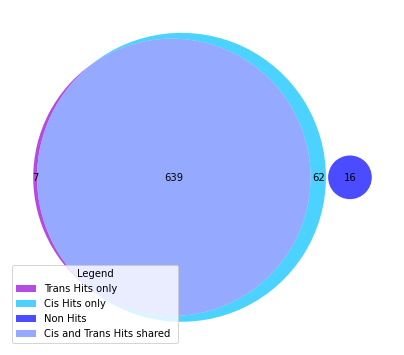

In [9]:
from collections import Counter
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt

sets = Counter()                  
sets['100'] = 7   
sets['010'] = 62   
sets['001'] = 16    
sets['110'] = 639    
sets['101'] = 0     
sets['111'] = 0 
labels = ('Cis', 'Trans', 'Non Hits')  
plt.figure(figsize=(7,7))
ax = plt.gca()
colors = ['darkviolet','deepskyblue','blue']
v = venn3(subsets=sets, set_labels=('','',''), ax=ax,set_colors=
          colors,alpha=0.7)   


h = [] 
for i in sets:
    h.append(v.get_patch_by_id(i)) 
l = ['Trans Hits only','Cis Hits only','Non Hits','Cis and Trans Hits shared ','',
     '','']
ax.legend(handles=h, labels=l, title="Legend",loc=3)  
#plt.title('Number of SNPs Hits ')
output_file = "/home/s417377/lastversion_gwas_analysis/overlapping_result/Perm_GWAS_Hits.png"
plt.savefig(output_file, dpi=700, facecolor='w')
plt.show()

<ipython-input-155-c91a4d062a27>:25: UserWarning: Legend does not support None instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ax.legend(handles=h, labels=l, title="Legend",loc=3)


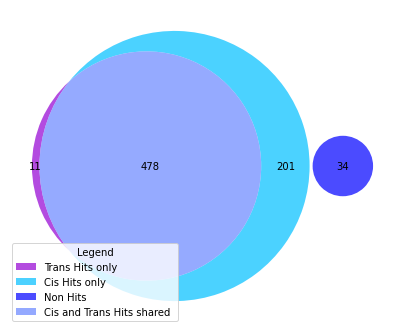

In [155]:
from collections import Counter
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt

sets = Counter()                  
sets['100'] = 11   
sets['010'] = 201     
sets['001'] = 34    
sets['110'] = 478     
sets['101'] = 0     
sets['111'] = 0 
labels = ('Cis', 'Trans', 'Non Hits')  
plt.figure(figsize=(7,7))
ax = plt.gca()
colors = ['darkviolet','deepskyblue','blue']
v = venn3(subsets=sets, set_labels=('','',''), ax=ax,set_colors=
          colors,alpha=0.7)   


h = [] 
for i in sets:
    h.append(v.get_patch_by_id(i)) 
l = ['Trans Hits only','Cis Hits only','Non Hits','Cis and Trans Hits shared ','',
     '','']
ax.legend(handles=h, labels=l, title="Legend",loc=3)  
#plt.title('Number of SNPs Hits ')
output_file = "~/lastversion_gwas_analysis/overlapping_result/GWAS_Hits.png"
plt.savefig(output_file, dpi=700, facecolor='w')
plt.show()

## Find common Trans genes 
The phenotype files of the 3 most significant trans genes in the duplicated files are determined. SNPs that cause these trans genes are determined from the results of gwas resulting from this phenotype. As an example, SNPs that cause significant trans genes in common are identified in files AT2G16365_AT1G13430 and AT1G13430_AT2G16365. In this way, these common SNPs are determined according to the results of gwas causing AT2G18735, AT1G08840 and AT2G21830 trans genes.

In [ ]:
%% R
#AT1G08840
#"AT1G13430_AT2G16365.csv"
setwd("~/trans_genes/AT1G08840")
Y <- list()
csvfiles<-list.files(pattern = "*.csv")
Y <- lapply(csvfiles, function(x) {
  file <- read.csv(x)
  return(file)
})
for (i in 1:length((csvfiles))){
  Y[[i]]<-mutate(Y[[i]], SNP=paste(CHR, sep="- ", POS))
}
d<-a[which("AT1G13430_AT2G16365.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}

for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[1]][,c(5,14)],by='SNP')
  b[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  b<-as.data.frame(b)
}  
  Z<-merge(mylist[[1]][,c(4,5)],Y[[1]][,c(5,14)],by='SNP')
  b<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
write.csv( b,"~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/SNPsAT1G08840_.csv", row.names = TRUE)
  
#"AT2G16365_AT1G13430.csv" 
d<-a[which("AT2G16365_AT1G13430.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
b1<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[2]][,c(5,14)],by='SNP')
  b1[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  b1<-as.data.frame(b1)
}  

#"AT2G16365_AT3G47010.csv"
d<-a[which("AT2G16365_AT3G47010.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
b2<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[3]][,c(5,14)],by='SNP')
  b2[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  b2<-as.data.frame(b2)
} 
#"AT3G47010_AT2G16365.csv" 
d<-a[which("AT3G47010_AT2G16365.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
b3<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[4]][,c(5,14)],by='SNP')
  b3[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  b3<-as.data.frame(b3)
  
} 
#"AT3G47010_AT4G00970.csv"
d<-a[which("AT3G47010_AT4G00970.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
b4<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[5]][,c(5,14)],by='SNP')
  b4[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  b4<-as.data.frame(b4)
  
} 
#"AT4G00970_AT3G47010.csv" 
d<-a[which("AT4G00970_AT3G47010.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
b5<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[6]][,c(5,14)],by='SNP')
  b5[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  b5<-as.data.frame(b5)
} 

#AT2G18735
setwd("/home/s417377/trans_genes/AT2G18735")
Y <- list()
csvfiles<-list.files(pattern = "*.csv")
Y <- lapply(csvfiles, function(x) {
  file <- read.csv(x)
  return(file)
})
for (i in 1:length((csvfiles))){
  Y[[i]]<-mutate(Y[[i]], SNP=paste(CHR, sep="- ", POS))
}
#"AT2G29710_AT2G24600.csv"
d<-a[which("AT2G29710_AT2G24600.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
f<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[1]][,c(5,14)],by='SNP')
  f[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  f<-as.data.frame(f)
} 
#"AT2G24600_AT2G29710.csv" 
d<-a[which("AT2G24600_AT2G29710.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
f1<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[2]][,c(5,14)],by='SNP')
  f1[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  f1<-as.data.frame(f1)
} 
#"AT2G24600_AT4G00970.csv"
d<-a[which("AT2G24600_AT4G00970.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
f2<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[3]][,c(5,14)],by='SNP')
  f2[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  f2<-as.data.frame(f2)
} 
#"AT3G12020_AT3G19040.csv" 
d<-a[which("AT3G12020_AT3G19040.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
f3<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[4]][,c(5,14)],by='SNP')
  f3[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  f3<-as.data.frame(f3)
} 
#"AT3G19040_AT3G12020.csv"
d<-a[which("AT3G19040_AT3G12020.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
f4<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[5]][,c(5,14)],by='SNP')
  f4[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  f4<-as.data.frame(f4)
} 
#"AT4G00970_AT2G24600.csv" 
d<-a[which("AT4G00970_AT2G24600.csv"==a$file_1),]
d<-unique(d$gens_trans)
d<-as.data.frame(d)
colnames(d)<-"gene"
mylist<-c()
for (i in 1:nrow(d)){
  e<-SNPs[which(d$gene[i]==SNPs$gene),]
  mylist[[length(mylist)+1]]<-e
  cat(i,'\n')
}
f5<-c()
for (i in 1:length((mylist))){
  Z<-merge(mylist[[i]][,c(4,5)],Y[[6]][,c(5,14)],by='SNP')
  f5[i]<-as.data.frame(paste(as.character(na.omit((Z$SNP))),collapse=','))
  f5<-as.data.frame(f5)
} 

## Manhattan Plot
The code used to visualize the GWAS results was written by Matthew Flickinger and modified according to the permgwas results "https://genome.sph.umich.edu/wiki/Code_Sample:_Generating_Manhattan_Plots_in_R" (manhattanplot2.r).

In [ ]:
%% R
library(lattice)
manhattan.plot<-function(chr, pos, pvalue, 
                         sig.level=NA, annotate=NULL, ann.default=list(),
                         should.thin=T, thin.pos.places=2, thin.logp.places=2, 
                         xlab="Chromosome", ylab=expression(-log[10](p-value)),
                         col=c("black","gray"), panel.extra=NULL, pch=20, cex=0.8,...) {
  
  if (length(chr)==0) stop("chromosome vector is empty")
  if (length(pos)==0) stop("position vector is empty")
  if (length(pvalue)==0) stop("pvalue vector is empty")
  
  #make sure we have an ordered factor
  if(!is.ordered(chr)) {
    chr <- ordered(chr)
  } else {
    chr <- chr[,drop=T]
  }
  
  #make sure positions are in kbp
  if (any(pos>1e6)) pos<-pos/1e6;
  
  #calculate absolute genomic position
  #from relative chromosomal positions
  posmin <- tapply(pos,chr, min);
  posmax <- tapply(pos,chr, max);
  posshift <- head(c(0,cumsum(posmax)),-1);
  names(posshift) <- levels(chr)
  genpos <- pos + posshift[chr];
  getGenPos<-function(cchr, cpos) {
    p<-posshift[as.character(cchr)]+cpos
    return(p)
  }
  
  #parse annotations
  grp <- NULL
  ann.settings <- list()
  label.default<-list(x="peak",y="peak",adj=NULL, pos=3, offset=0.5, 
                      col=NULL, fontface=NULL, fontsize=NULL, show=F)
  parse.label<-function(rawval, groupname) {
    r<-list(text=groupname)
    if(is.logical(rawval)) {
      if(!rawval) {r$show <- F}
    } else if (is.character(rawval) || is.expression(rawval)) {
      if(nchar(rawval)>=1) {
        r$text <- rawval
      }
    } else if (is.list(rawval)) {
      r <- modifyList(r, rawval)
    }
    return(r)
  }
  
  if(!is.null(annotate)) {
    if (is.list(annotate)) {
      grp <- annotate[[1]]
    } else {
      grp <- annotate
    } 
    if (!is.factor(grp)) {
      grp <- factor(grp)
    }
  } else {
    grp <- factor(rep(1, times=length(pvalue)))
  }
  
  ann.settings<-vector("list", length(levels(grp)))
  ann.settings[[1]]<-list(pch=pch, col=col, cex=cex, fill=col, label=label.default)
  
  if (length(ann.settings)>1) { 
    lcols<-trellis.par.get("superpose.symbol")$col 
    lfills<-trellis.par.get("superpose.symbol")$fill
    for(i in 2:length(levels(grp))) {
      ann.settings[[i]]<-list(pch=pch, 
                              col=lcols[(i-2) %% length(lcols) +1 ], 
                              fill=lfills[(i-2) %% length(lfills) +1 ], 
                              cex=cex, label=label.default);
      ann.settings[[i]]$label$show <- T
    }
    names(ann.settings)<-levels(grp)
  }
  for(i in 1:length(ann.settings)) {
    if (i>1) {ann.settings[[i]] <- modifyList(ann.settings[[i]], ann.default)}
    ann.settings[[i]]$label <- modifyList(ann.settings[[i]]$label, 
                                          parse.label(ann.settings[[i]]$label, levels(grp)[i]))
  }
  if(is.list(annotate) && length(annotate)>1) {
    user.cols <- 2:length(annotate)
    ann.cols <- c()
    if(!is.null(names(annotate[-1])) && all(names(annotate[-1])!="")) {
      ann.cols<-match(names(annotate)[-1], names(ann.settings))
    } else {
      ann.cols<-user.cols-1
    }
    for(i in seq_along(user.cols)) {
      if(!is.null(annotate[[user.cols[i]]]$label)) {
        annotate[[user.cols[i]]]$label<-parse.label(annotate[[user.cols[i]]]$label, 
                                                    levels(grp)[ann.cols[i]])
      }
      ann.settings[[ann.cols[i]]]<-modifyList(ann.settings[[ann.cols[i]]], 
                                              annotate[[user.cols[i]]])
    }
  }
  rm(annotate)
  
  #reduce number of points plotted
  if(should.thin) {
    thinned <- unique(data.frame(
      logp=round(-log10(pvalue),thin.logp.places), 
      pos=round(genpos,thin.pos.places), 
      chr=chr,
      grp=grp)
    )
    logp <- thinned$logp
    genpos <- thinned$pos
    chr <- thinned$chr
    grp <- thinned$grp
    rm(thinned)
  } else {
    logp <- -log10(pvalue)
  }
  rm(pos, pvalue)
  gc()
  
  #custom axis to print chromosome names
  axis.chr <- function(side,...) {
    if(side=="bottom") {
      panel.axis(side=side, outside=T,
                 at=((posmax+posmin)/2+posshift),
                 labels=levels(chr), 
                 ticks=F, rot=0,
                 check.overlap=F
      )
    } else if (side=="top" || side=="right") {
      panel.axis(side=side, draw.labels=F, ticks=F);
    }
    else {
      axis.default(side=side,...);
    }
  }
  
  #make sure the y-lim covers the range (plus a bit more to look nice)
  prepanel.chr<-function(x,y,...) { 
    A<-list();
    maxy<-ceiling(max(y, ifelse(!is.na(sig.level), -log10(sig.level), 0)))+.5;
    A$ylim=c(0,maxy);
    A;
  }
  
  xyplot(logp~genpos, chr=chr, groups=grp,
         axis=axis.chr, ann.settings=ann.settings, 
         prepanel=prepanel.chr, scales=list(axs="i"),
         panel=function(x, y, ..., getgenpos) {
           if(!is.na(sig.level)) {
             #add significance line (if requested)
             panel.abline(h=-log10(sig.level), lty=2);
           }
           panel.superpose(x, y, ..., getgenpos=getgenpos);
           if(!is.null(panel.extra)) {
             panel.extra(x,y, getgenpos, ...)
           }
         },
         panel.groups = function(x,y,..., subscripts, group.number) {
           A<-list(...)
           #allow for different annotation settings
           gs <- ann.settings[[group.number]]
           A$col.symbol <- gs$col[(as.numeric(chr[subscripts])-1) %% length(gs$col) + 1]    
           A$cex <- gs$cex[(as.numeric(chr[subscripts])-1) %% length(gs$cex) + 1]
           A$pch <- gs$pch[(as.numeric(chr[subscripts])-1) %% length(gs$pch) + 1]
           A$fill <- gs$fill[(as.numeric(chr[subscripts])-1) %% length(gs$fill) + 1]
           A$x <- x
           A$y <- y
           do.call("panel.xyplot", A)
           #draw labels (if requested)
           if(gs$label$show) {
             gt<-gs$label
             names(gt)[which(names(gt)=="text")]<-"labels"
             gt$show<-NULL
             if(is.character(gt$x) | is.character(gt$y)) {
               peak = which.max(y)
               center = mean(range(x))
               if (is.character(gt$x)) {
                 if(gt$x=="peak") {gt$x<-x[peak]}
                 if(gt$x=="center") {gt$x<-center}
               }
               if (is.character(gt$y)) {
                 if(gt$y=="peak") {gt$y<-y[peak]}
               }
             }
             if(is.list(gt$x)) {
               gt$x<-A$getgenpos(gt$x[[1]],gt$x[[2]])
             }
             do.call("panel.text", gt)
           }
         },
         xlab=xlab, ylab=ylab, 
         panel.extra=panel.extra, getgenpos=getGenPos, ...
  );
}


## Visualization
Manhattan plots  are drawn according to the  common SNPs are found of gwas causing AT2G18735, AT1G08840 and AT2G21830 trans genes (manhattanplot.r).

In [ ]:
%%R
library(tidyverse)
library(dplyr)
vignette('qqman')
ara11<-read.csv("~/lastversion_gwas_analysis/ara11_50.csv")
setwd("/home/s417377/trans_genes/AT2G18735/maf_filtered/")
Y <- list()
csvfiles<-list.files(pattern = "*.csv")
Y <- lapply(csvfiles, function(x) {
  file <- read.csv(x)
  return(file)
})
for (i in 1:length((csvfiles))){
  Y[[i]]<-mutate(Y[[i]], SNP=paste(CHR, sep="- ", POS))
}
for (i in 1:length((csvfiles))){
  colnames(Y[[i]])[4]<-"chr"
  colnames(Y[[i]])[5]<-"pos"
  colnames(Y[[i]])[6]<-"pvalue"
}
#"AT2G29710_AT2G24600"
#make annotation factor
ann<-rep(1, length(Y[[1]]$pvalue))
ann[with(Y[[1]], chr==2  &  pos>=12648573 &  pos<= 12750343)]<-2
ann[with(Y[[1]], chr==2  &  pos==9137974)]<-3
ann[with(Y[[1]], chr==2  &  pos==9303977)]<-4
ann[with(Y[[1]], chr==2  &  pos==17833766)]<-5
ann[with(Y[[1]], chr==4  &  pos==840051)]<-6
ann<-factor(ann, levels=1:6, labels=c("","-", "9137974","9303977","17833766","840051"))
#draw plot with annotation
manhattan.plot(Y[[1]]$chr, Y[[1]]$pos, Y[[1]]$pvalue, annotate=ann, ylim=c(0,50))
#"AT2G24600_AT2G29710"
#make annotation factor
ann<-rep(1, length(Y[[3]]$pvalue))
ann[with(Y[[3]], chr==2  &  pos>=10402034 &  pos<= 10504593)]<-2
ann[with(Y[[3]], chr==2  &  pos==9137974)]<-3
ann[with(Y[[3]], chr==2  &  pos==9303977)]<-4
ann[with(Y[[3]], chr==2  &  pos==17833769)]<-5
ann[with(Y[[3]], chr==4  &  pos==840051)]<-6
ann<-factor(ann, levels=1:6, labels=c("","-", "9137974","9303977","17833769","840051"))
#draw plot with annotation
manhattan.plot(Y[[3]]$chr, Y[[3]]$pos, Y[[3]]$pvalue, annotate=ann, ylim=c(0,50))
#"AT2G24600_AT4G00970.csv"
#make annotation factor
ann<-rep(1, length(Y[[2]]$pvalue))
ann[with(Y[[2]], chr==4  &  pos>=368327 &  pos<= 471885)]<-2
ann[with(Y[[2]], chr==2  &  pos==8122148)]<-3
ann[with(Y[[2]], chr==2  &  pos==9345189)]<-4
ann[with(Y[[2]], chr==2  &  pos==17833784)]<-5
ann[with(Y[[2]], chr==4  &  pos==839000)]<-6
ann<-factor(ann, levels=1:6, labels=c("","-", "8122148","9345189","17833784","839000"))
#draw plot with annotation
manhattan.plot(Y[[2]]$chr, Y[[2]]$pos, Y[[2]]$pvalue, annotate=ann, ylim=c(0,50))
#"AT4G00970_AT2G24600.csv"
#make annotation factor
ann<-rep(1, length(Y[[6]]$pvalue))
ann[with(Y[[6]], chr==2  &  pos>=10402034 &  pos<= 10504593)]<-2
ann[with(Y[[6]], chr==2  &  pos==8122148)]<-3
ann[with(Y[[6]], chr==2  &  pos==9345189)]<-4
ann[with(Y[[6]], chr==2  &  pos==17833784)]<-5
ann[with(Y[[6]], chr==4  &  pos==839000)]<-6
ann<-factor(ann, levels=1:6, labels=c("","-", "8122148","9345189","17833784","839000"))
#draw plot with annotation
manhattan.plot(Y[[6]]$chr, Y[[6]]$pos, Y[[6]]$pvalue, annotate=ann, ylim=c(0,50))
#"AT3G12020_AT3G19040.csv" 
ann<-rep(1, length(Y[[4]]$pvalue))
ann[with(Y[[4]], chr==3  &  pos>=6517021 &  pos<= 6517021)]<-2
ann[with(Y[[4]], chr==2  &  pos==8122723)]<-3
ann<-factor(ann, levels=1:3, labels=c("","-", "8122723"))
#draw plot with annotation
manhattan.plot(Y[[4]]$chr, Y[[4]]$pos, Y[[4]]$pvalue, annotate=ann, ylim=c(0,50))
#"AT3G19040_AT3G12020.csv" 
#make annotation factor
ann<-rep(1, length(Y[[5]]$pvalue))
ann[with(Y[[5]], chr==3  &  pos>=3775980 &  pos<= 3885146)]<-2
ann[with(Y[[5]], chr==2  &  pos==8122723)]<-3
ann<-factor(ann, levels=1:3, labels=c("","-", "8122723"))
#draw plot with annotation
manhattan.plot(Y[[5]]$chr, Y[[5]]$pos, Y[[5]]$pvalue, annotate=ann, ylim=c(0,50))

## Save Jupyter Notebook session

In [17]:
import dataframe_image as dfi
dfi.convert('/home/s417377/PermGwas.ipynb',
                to='pdf',
                use='latex',
                center_df=True,
                max_rows=30,
                max_cols=10,
                execute=False,
                save_notebook=False,
                limit=None,
                document_name=None,
                table_conversion='chrome'
                #chrome_path=None,
                #latex_command=None,
                #output_dir=None,
                )

## Add accesion ids
(accesion.r)

In [ ]:
%%R
setwd("~/lastversion_gwas_analysis/PermGWAS_OverCo/")
setwd("~/lastversion_gwas_analysis/PermGWAS_Scripts/AC_1_0_files/")
Y <- list()
csvfiles<-list.files(pattern = "*.csv")
Y <- lapply(csvfiles, function(x) {
  file <- read.csv(x)
  return(file)
})

d<-read.csv("~/lastversion_gwas_analysis/overlapping_result/perm_overlapping_genes.csv")
d['accesion']<-NA
for(i in 1:nrow(d)){
  a<-Y[[i]][which(Y[[i]]$Phenotype==1),]
  d[i,15]<-paste(as.character(na.omit(a$X)),collapse=',')
}
write.csv(d, "~/lastversion_gwas_analysis/overlapping_result/accesions_overlapping_genes.csv", row.names = FALSE)



  
  

In [ ]:
library(tidyverse)
library(fs)
library(readxl)
library(dplyr)
load("/storage/full-share/evolgen/snps_2029.rda")
small_gene<-read_excel("~/lastversion_gwas_analysis/Over_Occ/stringent_hits.xlsx")
#setwd("/home/s417377/lastversion_gwas_analysis/PermGWAS_Scripts/permgwas_premature/")
#b<-d[which(d$SNP==SNPs$SNP),]
#d[which("AT2G27340"==SNPs$SNP)&SNPs$prematSTOP==1,]
#cc<-SNPs[which("AT2G27340"==SNPs$SNP)&SNPs$prematSTOP==1,]
setwd("/home/s417377/PermGWAS/")
list_of_files <- list.files(path = "/home/s417377/PermGWAS",
                            recursive = TRUE,
                            pattern = "*gwasp_",
                            full.names = TRUE)
Y <- lapply(list_of_files, function(x) {
  file <- read.csv(x)
  return(file)
})
for (i in 1:length((list_of_files))){
  Y[[i]]<-mutate(Y[[i]], SNP=paste(CHR, sep="- ", POS))
}
setwd("/home/s417377/lastversion_gwas_analysis/PermGWAS_Scripts/permgwas_premature/")
for (i in 1:length((list_of_files))){
  a<-SNPs[which(small_gene$...3[[i]]==SNPs$gene),]
  a<-a[2:16]
  b<-a[which(a$prematSTOP==1),]
  for(x in 1:length((list_of_files))){
    c<-b[which(b$SNP[x]==Y[[i]]["SNP"]),]
    write.csv(c, file=paste( "premature_",small_gene$gen_name[[i]],".csv", sep=""))
  }
}

#a<-SNPs[which(small_gene$...3[[1]]==SNPs$gene),]
#a<-a[2:16]
#b<-a[which(a$prematSTOP==1),]
#c<-b[which(b$SNP[4]==Y[[1]]["SNP"]),]
#for(x in 1:length((list_of_files))){
 # c<-b[which(b$SNP[x]==Y[[1]]["SNP"]),]
  #write.csv(c, file=paste( "premature_",small_gene$gen_name[[i]],".csv", sep=""))
#}
